In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model
import pygtc
import time

In [2]:
def build_partials(p,zs,unc,dpar,nmodes):
    '''
    p      = vector of cosmological parameters (npar x 1)
    zs     = tuple of redshifts of interest
    unc    = vector of uncertainties (n_kmodes x 1)
    dpar   = vector (you might want dif step sizes for dif params) of step sizes (npar x 1)
    nmodes = [scalar] number of modes in the spectrum - could be l-modes for CMB, k-modes for 21 cm, etc.
    '''
    nprm=len(p)
    V=np.zeros((nmodes,nprm))
    for par in range(nprm):
        V[:,par]=CAMBpartial(p,zs,par,dpar)
    return V

def fisher(partials,unc):
    '''
    partials = nmodes x nprm array where each column is an nmodes x 1 vector of the PS's partial WRT a dif param
    unc      = nmodes x 1 vector of standard deviations at each mode (could be k-mode, l-mode, etc.)
    '''
    V=0.0*partials # want the same shape
    for i in range(nprm):
        V[:,i]=partials[:,i]/unc
    return V.T@V

scale=1e-9
def get_mps(pars,zs,kmax=2.0,linear=False,minkh=1e-4,maxkh=1,npts=200):
    '''
    get matter power spectrum 
    
    pars   = vector of cosmological parameters (npar x 1)
    zs     = redshifts of interest (**tuple** of floats)
    kmax   = max wavenumber to calculate the MPS for
    linear = if True, calc linear matter PS; else calc NL MPS (Boolean)
    minkh  = min value of k/h to calculate the MPS for
    maxkh  = max value of k/h to calculate the MPS for
    npts   = number of points in the calculated MPS
    '''
    zs=[zs]
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    As=pars[3]*scale ######## find a way to bake into the MPS calc?
    ns=pars[4]

    pars=camb.set_params(H0=H0, ombh2=ombh2, omch2=omch2, ns=ns, mnu=0.06,omk=0)
#     pars=camb.set_params(H0=H0, ombh2=ombh2, omch2=omch2, ns=ns, mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_matter_power(redshifts=zs, kmax=2.0)
    lin=True
    results = camb.get_results(pars)
    if lin:
        pars.NonLinear = model.NonLinear_none
    else:
        pars.NonLinear = model.NonLinear_both

    kh,z,pk=results.get_matter_power_spectrum(minkh=minkh,maxkh=maxkh,npoints=npts)
    return kh,pk

def CAMBpartial(p,zs,n,dpar):
    '''
    p    = vector of cosmological parameters (npar x 1)
    zs   = tuple of redshifts where we're interested in calculating the MPS
    n    = take the partial derivative WRT the nth parameter in p
    dpar = vector (you might want dif step sizes for dif params) of step sizes (npar x 1)
    '''
    nprm=len(p)
    kh,pk=get_mps(p,zs) # model should be get_spec for the unperturbed params
    npts=pk.shape[1]
    Ap=np.zeros([npts,1])
    pcopy=p.copy()
    pcopy[n]=pcopy[n]+dpar[n]
    khp,pkp=get_mps(pcopy,zs)
    fplus=np.array(pkp[:npts])
    pcopy=p.copy()
    pcopy[n]=pcopy[n]-dpar[n]
    khm,pkm=get_mps(pcopy,zs)
    fminu=np.array(pkm[:npts])
    return ((fplus-fminu)/(2*dpar[n])).reshape((npts,))

def cornerplot(fishermat,params,pnames,nsamp=10000,savename=None):
    cov=np.linalg.inv(fishermat)
    samples=np.random.multivariate_normal(params,cov,size=nsamp)
    GTC=pygtc.plotGTC(chains=samples,
                      paramNames=pnames,
                      truths=tuple(params),
                      plotName=savename)
    return None

In [3]:
# p0=np.asarray([67.7,0.022,0.119,0.056,2.1e-9, 0.97])
# pnames=['$H_0$','$\Omega_b h^2$','$\Omega_c h^2$','$\\tau$','$A_S$','$n_s$']
p0=np.asarray([67.7,0.022,0.119,2.1e-9, 0.97])
pnames=['$H_0$','$\Omega_b h^2$','$\Omega_c h^2$','$A_S$','$n_s$']
p0[3]/=scale
nprm=len(p0) # number of parameters
dpar=1e-3*np.ones(nprm)
dpar[3]*=scale
# ztest=tuple(np.arange(5,11))
# ztest=[3.7]
ztest=3.7
kh0,spec0=get_mps(p0,ztest,linear=True)

n_kmodes=spec0.shape[1]
p0_tuple=tuple(p0) # tuple version to keep pyGTC happy

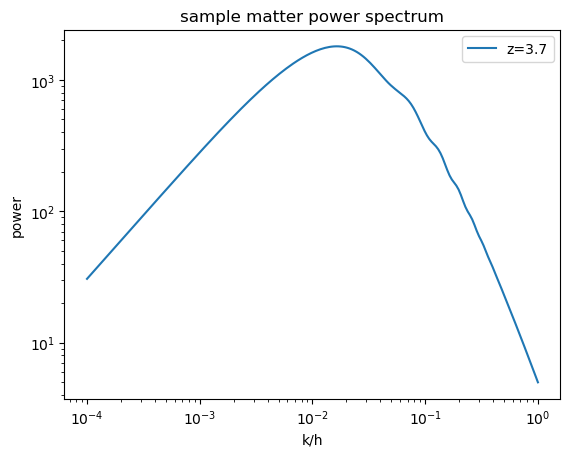

In [4]:
plt.figure()
if type(ztest)!=float:
    for zz in range(len(ztest)):
        plt.loglog(kh0,spec0[zz,:],label='z='+str(ztest[zz]))
else:
    plt.loglog(kh0,spec0[0,:],label='z='+str(ztest))
plt.xlabel('k/h')
plt.ylabel('power')
plt.title('sample matter power spectrum')
plt.legend()
plt.show()

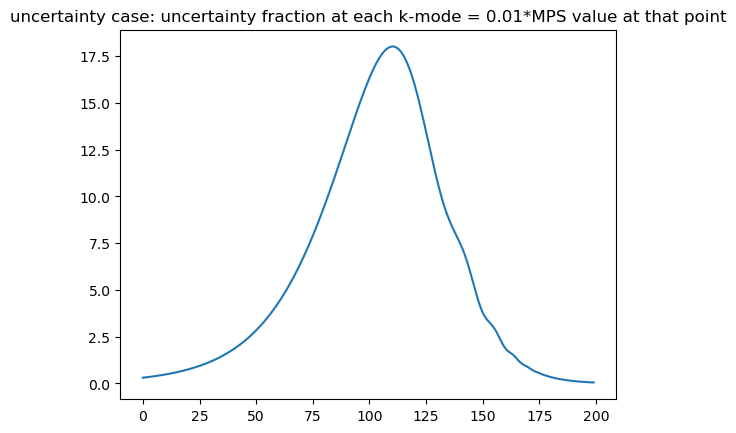

calculating the PS partials took 12.013179063796997 s


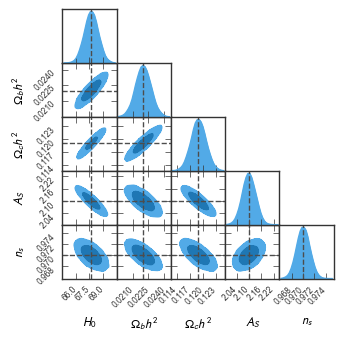

In [5]:
alpha=0.01
unc=alpha*spec0 # this says that the precision at each k-mode is alpha times the simulated spectrum value

plt.figure()
plt.plot(unc[0,:])
plt.title('uncertainty case: uncertainty fraction at each k-mode = '+str(alpha)+'*MPS value at that point')
plt.show()

INITIAL=False
if INITIAL:
    nmodes0=spec0.shape[1]
    t0=time.time()
    partials=build_partials(p0,ztest,unc,dpar,nmodes0)
    t1=time.time()
    print('calculating the PS partials took',t1-t0,'s')
    np.savetxt('camb_mps_partials_alpha.txt',partials)
else: 
    partials=np.genfromtxt('camb_mps_partials_alpha.txt')
fish=fisher(partials,unc)
# print(fish)

cornerplot(fish,p0,pnames,savename='test_mps_alpha.pdf')

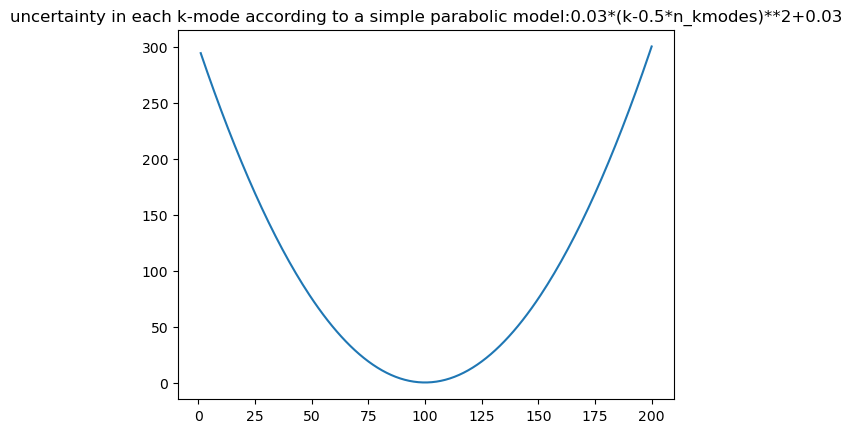

calculating the PS partials took 12.546974182128906 s


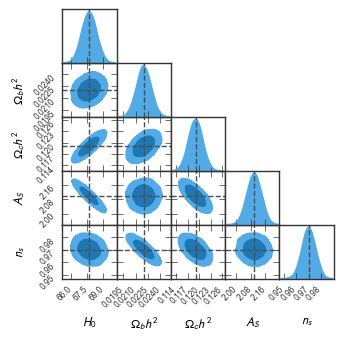

In [6]:
unc_x=np.arange(1,n_kmodes+1)
unc_prefac=0.03
unc=unc_prefac*(unc_x-n_kmodes/2)**2+unc_prefac # this says that the precision at each k-mode is alpha times the simulated spectrum value

plt.figure()
plt.plot(unc_x,unc)
plt.title('uncertainty in each k-mode according to a simple parabolic model:'+str(unc_prefac)+'*(k-0.5*n_kmodes)**2+'+str(unc_prefac))
plt.show()

INITIAL=False
if INITIAL:
    nmodes0=spec0.shape[1]
    t0=time.time()
    partials=build_partials(p0,ztest,unc,dpar,nmodes0)
    t1=time.time()
    print('calculating the PS partials took',t1-t0,'s')
    np.savetxt('camb_mps_partials_parab.txt',partials)
else: 
    partials=np.genfromtxt('camb_mps_partials_parab.txt')
fish=fisher(partials,unc)

cornerplot(fish,p0,pnames,savename='test_mps_parab.pdf')